# CNN 图像分类模型

In [1]:
# 导入
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


## 数据读取

In [3]:
# # 导入数据集fashion mnist
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
x_valid,x_train = x_train_all[:5000],x_train_all[5000:]
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]

print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
# 数据归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)

## CNN模型搭建

In [5]:
model = keras.models.Sequential()
# 构建模型
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                              activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

# 模型编译，固化模型
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [7]:
# 定义文件夹和文件
logdir = os.path.join('cnn-models')
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,'fashion_mnist_model.h5')

# 定义回调函数
callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir,profile_batch = 100000000),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),
]

# 训练
history = model.fit(x_train_scaled,y_train,epochs=10,
                    validation_data=(x_valid_scaled,y_valid),
                    callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 40s 731us/sample - loss: 0.4236 - accuracy: 0.8439 - val_loss: 0.3182 - val_accuracy: 0.8824
Epoch 2/10
55000/55000 [==============================] - 31s 557us/sample - loss: 0.2629 - accuracy: 0.9041 - val_loss: 0.2360 - val_accuracy: 0.9112
Epoch 3/10
55000/55000 [==============================] - 30s 554us/sample - loss: 0.2190 - accuracy: 0.9208 - val_loss: 0.2279 - val_accuracy: 0.9156
Epoch 4/10
55000/55000 [==============================] - 31s 555us/sample - loss: 0.1893 - accuracy: 0.9302 - val_loss: 0.2431 - val_accuracy: 0.9114
Epoch 5/10
55000/55000 [==============================] - 31s 555us/sample - loss: 0.1676 - accuracy: 0.9385 - val_loss: 0.2214 - val_accuracy: 0.9202
Epoch 6/10
55000/55000 [==============================] - 31s 556us/sample - loss: 0.1457 - accuracy: 0.9458 - val_loss: 0.2183 - val_accuracy: 0.9194
Epoch 7/10
55000/55000 [=====================

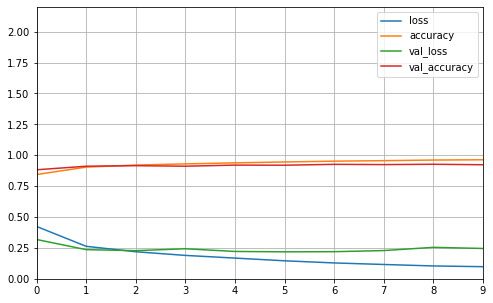

In [8]:
# 画图展示学习曲线图
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [ ]:
model.evaluate(x_test_scaled, y_test)

## 更改激活函数

In [10]:
model = keras.models.Sequential()
# 构建模型
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                              activation='selu', input_shape=(28,28,1)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='selu'))
model.add(keras.layers.Dense(10, activation='softmax'))

# 模型编译，固化模型
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
# 定义文件夹和文件
logdir = os.path.join('cnn-selu-models')
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,'fashion_mnist_model.h5')

# 定义回调函数
callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir,profile_batch = 100000000),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),
]

# 训练
history_selu = model.fit(x_train_scaled,y_train,epochs=10,
                         validation_data=(x_valid_scaled,y_valid),
                         callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 53s 959us/sample - loss: 0.4177 - accuracy: 0.8509 - val_loss: 0.3158 - val_accuracy: 0.8884
Epoch 2/10
55000/55000 [==============================] - 52s 941us/sample - loss: 0.3110 - accuracy: 0.8875 - val_loss: 0.2900 - val_accuracy: 0.8982
Epoch 3/10
55000/55000 [==============================] - 51s 934us/sample - loss: 0.2899 - accuracy: 0.8948 - val_loss: 0.3436 - val_accuracy: 0.8820
Epoch 4/10
55000/55000 [==============================] - 51s 936us/sample - loss: 0.2564 - accuracy: 0.9086 - val_loss: 0.2628 - val_accuracy: 0.9050
Epoch 5/10
55000/55000 [==============================] - 51s 933us/sample - loss: 0.2445 - accuracy: 0.9122 - val_loss: 0.2742 - val_accuracy: 0.9028
Epoch 6/10
55000/55000 [==============================] - 51s 933us/sample - loss: 0.2282 - accuracy: 0.9182 - val_loss: 0.2624 - val_accuracy: 0.9100
Epoch 7/10
55000/55000 [=====================

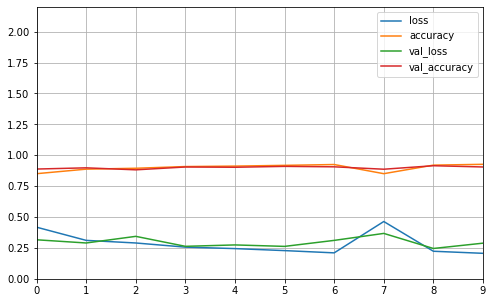

In [12]:
plot_learning_curves(history_selu)

In [ ]:
model.evaluate(x_test_scaled, y_test)

## 深度可分离卷积 Separable CNN

In [5]:
model = keras.models.Sequential()
# 构建模型
model.add(keras.layers.Conv2D(
    filters=32, kernel_size=3, padding='same',activation='selu', input_shape=(28,28,1)))
model.add(keras.layers.SeparableConv2D(
    filters=32, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.SeparableConv2D(
    filters=64, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.SeparableConv2D(
    filters=64, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.SeparableConv2D(
    filters=128, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.SeparableConv2D(
    filters=128, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='selu'))
model.add(keras.layers.Dense(10, activation='softmax'))

# 模型编译，固化模型
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
separable_conv2d (SeparableC (None, 28, 28, 32)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 14, 14, 64)        2400      
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 14, 14, 64)        4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 7, 7, 128)         8

In [7]:
# 定义文件夹和文件
logdir = os.path.join('separable-cnn-selu-models')
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,'fashion_mnist_model.h5')

# 定义回调函数
callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir,profile_batch = 100000000),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),
]

# 训练
history_separable_cnn = model.fit(x_train_scaled,y_train,epochs=10,
                                  validation_data=(x_valid_scaled,y_valid),
                                  callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 50s 911us/sample - loss: 0.5131 - accuracy: 0.8119 - val_loss: 0.3622 - val_accuracy: 0.8690
Epoch 2/10
55000/55000 [==============================] - 46s 832us/sample - loss: 0.3105 - accuracy: 0.8872 - val_loss: 0.2972 - val_accuracy: 0.8864
Epoch 3/10
55000/55000 [==============================] - 45s 821us/sample - loss: 0.2660 - accuracy: 0.9015 - val_loss: 0.2700 - val_accuracy: 0.9012
Epoch 4/10
55000/55000 [==============================] - 46s 827us/sample - loss: 0.2340 - accuracy: 0.9130 - val_loss: 0.2430 - val_accuracy: 0.9082
Epoch 5/10
55000/55000 [==============================] - 46s 836us/sample - loss: 0.2098 - accuracy: 0.9235 - val_loss: 0.2461 - val_accuracy: 0.9100
Epoch 6/10
55000/55000 [==============================] - 46s 837us/sample - loss: 0.1897 - accuracy: 0.9294 - val_loss: 0.2487 - val_accuracy: 0.9080
Epoch 7/10
55000/55000 [=====================

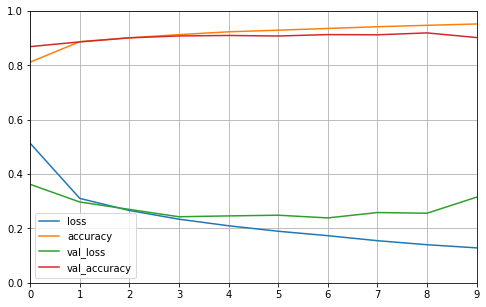

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history_separable_cnn)

In [ ]:
model.evaluate(x_test_scaled, y_test)